In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os

from sklearn.metrics import accuracy_score

# Problem #1

In [4]:
os.chdir('../../../Downloads/intel/')       

In [5]:
print(f'Current Directory: {os.getcwd().split("/")[-1]}')
print(f'Directory Contents: {os.listdir()}')

Current Directory: intel
Directory Contents: ['seg_pred', 'seg_test', 'seg_train']


In [6]:
directories = ['seg_train', 'seg_test', 'seg_pred']

In [7]:
# prints image counts and their class sub-directories
def get_info(directories):
    for i in directories:
        path = f'./{i}/{i}/'
        
        labels = os.listdir(path)
        
        print(f'{i} Image Count')
        
        total = 0
        
        try:
            for j in labels:
                count = len(os.listdir(path+j))
                print(f'\t{j}: {count}')
                total += count
    
        except:
            count = len(labels)
            print(f'\t{count} Images')
            total += count
        
        print(f'\n\tTOTAL: {total}')
            
        print('\n')

In [8]:
get_info(directories)

seg_train Image Count
	forest: 2271
	street: 2382
	buildings: 2191
	sea: 2274
	mountain: 2512
	glacier: 2404

	TOTAL: 14034


seg_test Image Count
	forest: 474
	street: 501
	buildings: 437
	sea: 510
	mountain: 525
	glacier: 553

	TOTAL: 3000


seg_pred Image Count
	7301 Images

	TOTAL: 7301




In [9]:
labels = ['forest', 'street', 'buildings', 'sea', 'mountain', 'glacier']

IMGSIZE = (128,128)

In [10]:
# function to load train and test images
def load_images(path, X, y):
    for f in sorted([pic for pic in os.listdir(path) if pic.lower().endswith('.jpg')]):
        X += [cv2.resize(cv2.imread(os.path.join(path, f)), IMGSIZE)]
        y += [labels.index(label)]
        
    return X, y

In [11]:
# load training and test images
X_tr, y_tr, X_ts, y_ts = [], [], [], []

for label in labels:
    # load training images
    train_path = './seg_train/seg_train/' + label
    X_tr, y_tr = load_images(train_path, X_tr, y_tr)
    
    # load test images
    test_path = './seg_test/seg_test/' + label
    X_ts, y_ts = load_images(test_path, X_ts, y_ts)

In [12]:
# sanity check
print(f'X_train: {len(X_tr)}')
print(f'y_train: {len(y_tr)}')
print(f'X_test:  {len(X_ts)}')
print(f'y_test:  {len(y_ts)}')

X_train: 14034
y_train: 14034
X_test:  3000
y_test:  3000


In [13]:
# observe channels
print(X_tr[0].shape)

(128, 128, 3)


Above, we see that for each image, there are **3 channels**, each 128x128 pixels in size. Each channel corresponds to the RGB channels

In [14]:
from mpl_toolkits.axes_grid1 import ImageGrid

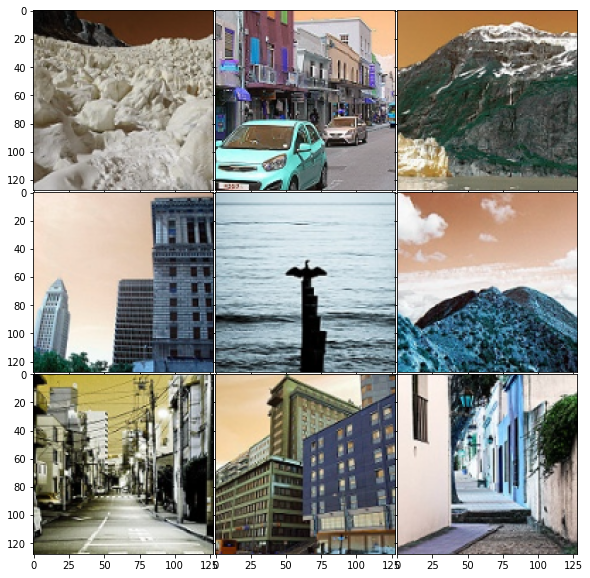

In [15]:
# see some images
samples = random.sample(X_tr, 9)

fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, rect=111, nrows_ncols=(3,3))

for ax, image in zip(grid, samples):
    ax.imshow(image)

plt.show()

# Problem #2

In [14]:
RGB_MAX = 255

In [15]:
# convert to numpy array
X_tr = np.array(X_tr, dtype=np.float)
y_tr = np.array(y_tr, dtype=np.float)

X_ts = np.array(X_ts, dtype=np.float)
y_ts = np.array(y_ts, dtype=np.float)

In [16]:
# normalize
X_tr  = X_tr / RGB_MAX
X_ts = X_ts / RGB_MAX

In [17]:
# sanity check
print('Dataset Shapes:\n')

print(f'X_train: {X_tr.shape}')
print(f'y_train: {y_tr.shape}')
print(f'X_test:  {X_ts.shape}')
print(f'y_test:  {y_ts.shape}')

Dataset Shapes:

X_train: (14034, 128, 128, 3)
y_train: (14034,)
X_test:  (3000, 128, 128, 3)
y_test:  (3000,)


# Problem #3

In [25]:
# intialize CNN model
cnn = tf.keras.Sequential()

cnn.add(tf.keras.layers.Conv2D(filters=16,
                               kernel_size=(4,4),
                              activation='relu',
                       data_format='channels_last',
                       name='conv_1'))

cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_1'))
cnn.add(tf.keras.layers.Conv2D(filters=32,
                               kernel_size=(4, 4),
                               activation='relu',
                               data_format='channels_last',
                              name='conv_2'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_2'))

cnn.add(tf.keras.layers.Flatten())

# fully connected layers
cnn.add(tf.keras.layers.Dense(units=1024, name='fc_1', activation='relu'))
cnn.add(tf.keras.layers.Dense(units=6, name='fc_2', activation='softmax'))

In [28]:
# set random seed
tf.random.set_seed(7)

# clear session
tf.keras.backend.clear_session()

cnn.build(input_shape=(None, 128, 128, 3))
cnn.compile(optimizer=tf.keras.optimizers.Adam(),
           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
           metrics=['accuracy'])

In [18]:
NUM_EPOCHS = 10

In [30]:
%%time
# train
result = cnn.fit(X_tr, y_tr, epochs=NUM_EPOCHS, shuffle=True)

2021-08-24 20:46:17.227722: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2759196672 exceeds 10% of free system memory.
2021-08-24 20:46:23.437205: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
439/439 [==============================] - 90s 205ms/step - loss: 0.9793 - accuracy: 0.6446
Epoch 2/10
439/439 [==============================] - 91s 208ms/step - loss: 0.5617 - accuracy: 0.7964
Epoch 3/10
439/439 [==============================] - 91s 206ms/step - loss: 0.3345 - accuracy: 0.8821
Epoch 4/10
439/439 [==============================] - 91s 208ms/step - loss: 0.1585 - accuracy: 0.9483
Epoch 5/10
439/439 [==============================] - 92s 210ms/step - loss: 0.0836 - accuracy: 0.9734
Epoch 6/10
439/439 [==============================] - 90s 206ms/step - loss: 0.0503 - accuracy: 0.9868
Epoch 7/10
439/439 [==============================] - 90s 206ms/step - loss: 0.0518 - accuracy: 0.9853
Epoch 8/10
439/439 [==============================] - 91s 206ms/step - loss: 0.0436 - accuracy: 0.9880
Epoch 9/10
439/439 [==============================] - 91s 208ms/step - loss: 0.0326 - accuracy: 0.9915
Epoch 10/10
439/439 [==============================] - 90s 205ms/step - l

In [19]:
# test
def test(model, X_ts, y_ts):
    y_pred = np.argmax(model.predict(X_ts), axis=-1)
    acc = accuracy_score(y_pred, y_ts)
    
    return acc

In [37]:
cnn_test_acc = test(cnn, X_ts)
print(f'Accuracy: {cnn_test_acc}')

2021-08-24 21:08:11.719355: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 589824000 exceeds 10% of free system memory.


Accuracy: 0.762


Above we see that the model achieves about **98% training accuracy**. However, when predicting on the out of sample test set, the model achieves **76.2% test accuracy**.

This means that the model is overfitting on the training data. Regularization should be implemented to improve model generalizability

# Problem #4

### Regularization

Let's apply L1 regularization as it will push useless weights to zero. Relu will thus inactivate these weights, leading to only essential forward pass and back propogation.

In [22]:
# regularization
L1 = tf.keras.regularizers.L1(l=0.01)

In [42]:
# intialize CNN model
cnn2 = tf.keras.Sequential()

cnn2.add(tf.keras.layers.Conv2D(filters=16,
                               kernel_size=(4,4),
                              activation='relu',
                               kernel_regularizer=L1,
                       data_format='channels_last',
                       name='conv_1'))

cnn2.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_1'))
cnn2.add(tf.keras.layers.Conv2D(filters=32,
                               kernel_size=(4, 4),
                               activation='relu',
                               kernel_regularizer=L1,
                               data_format='channels_last',
                              name='conv_2'))
cnn2.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_2'))

cnn2.add(tf.keras.layers.Flatten())

# fully connected layers
cnn2.add(tf.keras.layers.Dense(units=1024, name='fc_1', activation='relu'))
cnn2.add(tf.keras.layers.Dense(units=6, name='fc_2', activation='softmax'))

In [44]:
# set random seed
tf.random.set_seed(7)

# clear session
tf.keras.backend.clear_session()

cnn2.build(input_shape=(None, 128, 128, 3))
cnn2.compile(optimizer=tf.keras.optimizers.Adam(),
           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
           metrics=['accuracy'])

In [45]:
%%time
# train
result2 = cnn2.fit(X_tr, y_tr, epochs=NUM_EPOCHS, shuffle=True)

2021-08-24 21:27:11.856891: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2759196672 exceeds 10% of free system memory.


Epoch 1/10
439/439 [==============================] - 87s 197ms/step - loss: 2.4723 - accuracy: 0.6040
Epoch 2/10
439/439 [==============================] - 91s 207ms/step - loss: 1.3204 - accuracy: 0.7052
Epoch 3/10
439/439 [==============================] - 91s 207ms/step - loss: 1.0189 - accuracy: 0.7557
Epoch 4/10
439/439 [==============================] - 90s 206ms/step - loss: 0.8294 - accuracy: 0.8030
Epoch 5/10
439/439 [==============================] - 90s 206ms/step - loss: 0.6959 - accuracy: 0.8391
Epoch 6/10
439/439 [==============================] - 90s 205ms/step - loss: 0.5742 - accuracy: 0.8862
Epoch 7/10
439/439 [==============================] - 90s 205ms/step - loss: 0.4813 - accuracy: 0.9139
Epoch 8/10
439/439 [==============================] - 90s 205ms/step - loss: 0.3950 - accuracy: 0.9437
Epoch 9/10
439/439 [==============================] - 91s 207ms/step - loss: 0.3457 - accuracy: 0.9622
Epoch 10/10
439/439 [==============================] - 91s 207ms/step - l

In [46]:
cnn2_test_acc = test(cnn2, X_ts, y_ts)
print(f'Accuracy: {cnn2_test_acc}')

2021-08-24 21:43:49.470945: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 589824000 exceeds 10% of free system memory.


Accuracy: 0.75


### Dropout

In [24]:
# intialize CNN model
cnn3 = tf.keras.Sequential()

cnn3.add(tf.keras.layers.Conv2D(filters=16,
                               kernel_size=(4,4),
                              activation='relu',
                       data_format='channels_last',
                       name='conv_1'))

cnn3.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_1'))

cnn3.add(tf.keras.layers.Dropout(0.2))

cnn3.add(tf.keras.layers.Conv2D(filters=32,
                               kernel_size=(4, 4),
                               activation='relu',
                               data_format='channels_last',
                              name='conv_2'))
cnn3.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_2'))

cnn3.add(tf.keras.layers.Dropout(0.2))

cnn3.add(tf.keras.layers.Flatten())

# fully connected layers
cnn3.add(tf.keras.layers.Dense(units=1024, name='fc_1', activation='relu'))
cnn3.add(tf.keras.layers.Dense(units=6, name='fc_2', activation='softmax'))

In [25]:
# set random seed
tf.random.set_seed(7)

# clear session
tf.keras.backend.clear_session()

cnn3.build(input_shape=(None, 128, 128, 3))
cnn3.compile(optimizer=tf.keras.optimizers.Adam(),
           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
           metrics=['accuracy'])

In [26]:
%%time
# train
result3 = cnn3.fit(X_tr, y_tr, epochs=NUM_EPOCHS, shuffle=True)

2021-08-24 21:50:38.743811: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2759196672 exceeds 10% of free system memory.
2021-08-24 21:50:45.798399: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
439/439 [==============================] - 93s 211ms/step - loss: 1.0684 - accuracy: 0.6266
Epoch 2/10
439/439 [==============================] - 96s 218ms/step - loss: 0.6640 - accuracy: 0.7537
Epoch 3/10
439/439 [==============================] - 94s 215ms/step - loss: 0.4833 - accuracy: 0.8249
Epoch 4/10
439/439 [==============================] - 95s 216ms/step - loss: 0.3260 - accuracy: 0.8844
Epoch 5/10
439/439 [==============================] - 94s 214ms/step - loss: 0.2287 - accuracy: 0.9196
Epoch 6/10
439/439 [==============================] - 94s 215ms/step - loss: 0.1250 - accuracy: 0.9567
Epoch 7/10
439/439 [==============================] - 94s 214ms/step - loss: 0.1039 - accuracy: 0.9662
Epoch 8/10
439/439 [==============================] - 94s 213ms/step - loss: 0.0798 - accuracy: 0.9755
Epoch 9/10
439/439 [==============================] - 94s 214ms/step - loss: 0.0590 - accuracy: 0.9810
Epoch 10/10
439/439 [==============================] - 94s 215ms/step - l

In [29]:
cnn3_test_acc = test(cnn3, X_ts, y_ts)
print(f'Accuracy: {cnn3_test_acc}')

Accuracy: 0.7476666666666667


### Regularization & Dropout

In [21]:
# intialize CNN model
cnn4 = tf.keras.Sequential()

cnn4.add(tf.keras.layers.Conv2D(filters=16,
                               kernel_size=(4,4),
                              activation='relu',
                               kernel_regularizer=L1,
                       data_format='channels_last',
                       name='conv_1'))
cnn4.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_1'))

cnn4.add(tf.keras.layers.Dropout(0.2))

cnn4.add(tf.keras.layers.Conv2D(filters=32,
                               kernel_size=(4, 4),
                               activation='relu',
                               kernel_regularizer=L1,
                               data_format='channels_last',
                              name='conv_2'))
cnn4.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_2'))

cnn4.add(tf.keras.layers.Dropout(0.2))

cnn4.add(tf.keras.layers.Flatten())

# fully connected layers
cnn4.add(tf.keras.layers.Dense(units=1024, name='fc_1', activation='relu'))
cnn4.add(tf.keras.layers.Dense(units=6, name='fc_2', activation='softmax'))

In [22]:
# set random seed
tf.random.set_seed(7)

# clear session
tf.keras.backend.clear_session()

cnn4.build(input_shape=(None, 128, 128, 3))
cnn4.compile(optimizer=tf.keras.optimizers.Adam(),
           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
           metrics=['accuracy'])

In [23]:
%%time
# train
result4 = cnn4.fit(X_tr, y_tr, epochs=NUM_EPOCHS, shuffle=True)

2021-08-24 22:11:38.240429: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2759196672 exceeds 10% of free system memory.
2021-08-24 22:11:45.298306: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
439/439 [==============================] - 124s 282ms/step - loss: 2.5448 - accuracy: 0.5931
Epoch 2/10
439/439 [==============================] - 129s 294ms/step - loss: 1.3217 - accuracy: 0.6845
Epoch 3/10
439/439 [==============================] - 127s 290ms/step - loss: 1.0543 - accuracy: 0.7287
Epoch 4/10
439/439 [==============================] - 132s 301ms/step - loss: 0.8881 - accuracy: 0.7660
Epoch 5/10
439/439 [==============================] - 135s 308ms/step - loss: 0.7897 - accuracy: 0.7876
Epoch 6/10
439/439 [==============================] - 135s 308ms/step - loss: 0.6998 - accuracy: 0.8205
Epoch 7/10
439/439 [==============================] - 135s 309ms/step - loss: 0.6339 - accuracy: 0.8410
Epoch 8/10
439/439 [==============================] - 136s 310ms/step - loss: 0.5406 - accuracy: 0.8800
Epoch 9/10
439/439 [==============================] - 136s 310ms/step - loss: 0.4882 - accuracy: 0.8955
Epoch 10/10
439/439 [==============================] - 136s 310m

In [24]:
cnn4_test_acc = test(cnn4, X_ts, y_ts)
print(f'Accuracy: {cnn4_test_acc}')

Accuracy: 0.7566666666666667


### Regularization & Only 1 Dropout Layer

In [23]:
# intialize CNN model
cnn5 = tf.keras.Sequential()

cnn5.add(tf.keras.layers.Conv2D(filters=16,
                               kernel_size=(4,4),
                              activation='relu',
                               kernel_regularizer=L1,
                       data_format='channels_last',
                       name='conv_1'))
cnn5.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_1'))

cnn5.add(tf.keras.layers.Conv2D(filters=32,
                               kernel_size=(4, 4),
                               activation='relu',
                               kernel_regularizer=L1,
                               data_format='channels_last',
                              name='conv_2'))
cnn5.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_2'))

cnn5.add(tf.keras.layers.Dropout(0.2))

cnn5.add(tf.keras.layers.Flatten())

# fully connected layers
cnn5.add(tf.keras.layers.Dense(units=1024, name='fc_1', activation='relu'))
cnn5.add(tf.keras.layers.Dense(units=6, name='fc_2', activation='softmax'))

In [25]:
# set random seed
tf.random.set_seed(7)

# clear session
tf.keras.backend.clear_session()

cnn5.build(input_shape=(None, 128, 128, 3))
cnn5.compile(optimizer=tf.keras.optimizers.Adam(),
           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
           metrics=['accuracy'])

In [26]:
%%time
# train
result5 = cnn5.fit(X_tr, y_tr, epochs=NUM_EPOCHS, shuffle=True)

2021-08-24 22:37:31.629450: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2759196672 exceeds 10% of free system memory.
2021-08-24 22:37:38.590126: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
439/439 [==============================] - 135s 307ms/step - loss: 2.4713 - accuracy: 0.6011
Epoch 2/10
439/439 [==============================] - 133s 304ms/step - loss: 1.3316 - accuracy: 0.7015
Epoch 3/10
439/439 [==============================] - 133s 303ms/step - loss: 1.0485 - accuracy: 0.7453
Epoch 4/10
439/439 [==============================] - 132s 301ms/step - loss: 0.8708 - accuracy: 0.7912
Epoch 5/10
439/439 [==============================] - 131s 299ms/step - loss: 0.7530 - accuracy: 0.8232
Epoch 6/10
439/439 [==============================] - 131s 299ms/step - loss: 0.6304 - accuracy: 0.8646
Epoch 7/10
439/439 [==============================] - 131s 299ms/step - loss: 0.5303 - accuracy: 0.8949
Epoch 8/10
439/439 [==============================] - 131s 299ms/step - loss: 0.4639 - accuracy: 0.9179
Epoch 9/10
439/439 [==============================] - 132s 301ms/step - loss: 0.4007 - accuracy: 0.9424
Epoch 10/10
439/439 [==============================] - 133s 303m

In [27]:
cnn5_test_acc = test(cnn5, X_ts, y_ts)
print(f'Accuracy: {cnn5_test_acc}')

Accuracy: 0.7506666666666667


### Accuracy Summary On Test Set

**Base CNN:** 76.2%

**L1:** 75%

**2 Dropout Layers:** 74.7%

**L1 & 2 Dropout Layers:** 75.6%

**L1 & 1 Dropout Layer:** 75.1%

Overall we see that regularization and dropout methods do not help improve performance much. This could be due to the model architecture itself or that the model requires further hyperparemeter tuning. Possible improvements could be to improve the number of epochs, change the regularizer to L2, or increase the dropout rate.